# Multisensor rail detection in automatic train operations - Splitting dataset and labeling

Attila Kovacs
25.11.2023


## Introduction

In this notebeook, we will split the dataset into train, validation, and test set.
For each dataset, we generate the labels and store the files in the required directory structure.


## Load required packages and dataset

In [7]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import json
from datetime import datetime
from sklearn.model_selection import train_test_split


import os
#import shutil
from random import randint
import seaborn as sns
import warnings
from utils import generate_train_val_test_split, find_contours, generate_mask_df, write_dataset_to_directory
%matplotlib inline

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'



In [8]:
max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime)

'./dataframe_dumps\\df_eda_10-20-2023_17-05-21.json'

In [9]:
df_db = pd.read_json(max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime))

In [10]:
max(glob("./dataframe_dumps/df_railsem_eda_*"), key=os.path.getmtime)

'./dataframe_dumps\\df_railsem_eda_11-25-2023_09-41-12.json'

In [11]:
df_railsem = pd.read_json(
    max(glob("./dataframe_dumps/df_railsem_eda_*"), key=os.path.getmtime)
)

## Perform data split - DB

Given the fact that certain images (e.g. frames from a video that was take when the locomotive was standing still), we perform a random split not on individual images but on videos sequences.
We aim for a 70/15/15 split over the number of images. However, as the number of images varies for different video sequences it is not possible to generate the exact split.

seed: 93
set
train    5506
val       987
test      928
Name: count, dtype: int64


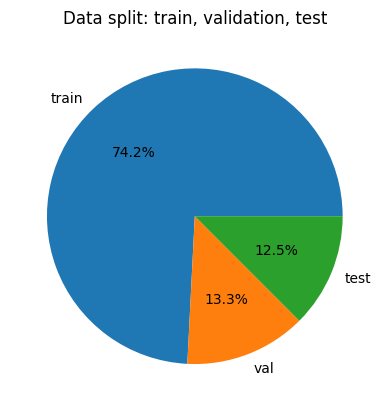

In [12]:
# seed = randint(0, 100)
seed = 93
print(f"seed: {seed}")
df_split = generate_train_val_test_split(
    df=df_db, seed=seed, val_ratio=0.15, test_ratio=0.15
)
temp = df_split[["path", "set"]].drop_duplicates()["set"].value_counts()
print(temp)

labels = temp.index
values = temp.values
plt.pie(values, labels=labels, autopct="%.1f%%")
_ = plt.title("Data split: train, validation, test")

### Train set

In [13]:
df_split[df_split["set"] == "train"].tag.unique()

array(['10_station_suelldorf_10.1', '11_main_station_11.1',
       '12_vegetation_steady_12.1', '13_station_ohlsdorf_13.1',
       '14_signals_station_14.2', '14_signals_station_14.3',
       '15_construction_vehicle_15.1', '17_signal_bridge_17.1',
       '19_vegetation_curve_19.1', '1_calibration_1.1',
       '20_vegetation_squirrel_20.1', '21_station_wedel_21.2',
       '21_station_wedel_21.3', '2_station_berliner_tor_2.1',
       '3_fire_site_3.1', '3_fire_site_3.2', '3_fire_site_3.4',
       '4_station_pedestrian_bridge_4.1',
       '4_station_pedestrian_bridge_4.3',
       '4_station_pedestrian_bridge_4.4', '5_station_bergedorf_5.1',
       '5_station_bergedorf_5.2', '6_station_klein_flottbek_6.1',
       '6_station_klein_flottbek_6.2',
       '7_approach_underground_station_7.1',
       '7_approach_underground_station_7.3', '8_station_altona_8.1',
       '8_station_altona_8.2', '9_station_ruebenkamp_9.3',
       '9_station_ruebenkamp_9.4', '9_station_ruebenkamp_9.5',
       '9_st

### Validation set

In [14]:
df_split[df_split["set"] == "val"].tag.unique()

array(['16_under_bridge_16.1', '18_vegetation_switch_18.1',
       '1_calibration_1.2', '3_fire_site_3.3', '9_station_ruebenkamp_9.1',
       '9_station_ruebenkamp_9.2'], dtype=object)

### Test set

In [15]:
df_split[df_split["set"] == "test"].tag.unique()

array(['14_signals_station_14.1', '21_station_wedel_21.1',
       '4_station_pedestrian_bridge_4.2',
       '4_station_pedestrian_bridge_4.5',
       '7_approach_underground_station_7.2', '8_station_altona_8.3'],
      dtype=object)

## Perform data split - RailSem

In [16]:
seed = 93
print(f"seed: {seed}")

seed: 93


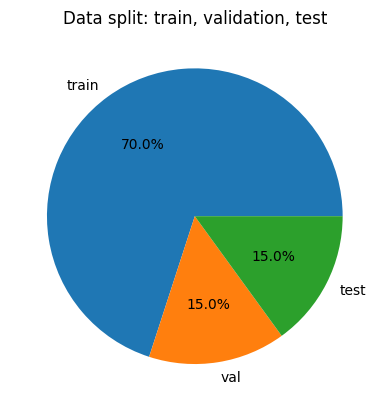

In [17]:
y = np.zeros(len(df_railsem["path"].unique()))
X_train, X_test, y_train, y_test = train_test_split(
    df_railsem["path"].unique(), y, test_size=0.15, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=15 / 85, random_state=seed
)
values = [len(X_train), len(X_val), len(X_test)]
labels = ["train", "val", "test"]
plt.pie(values, labels=labels, autopct="%.1f%%")
_ = plt.title("Data split: train, validation, test")

In [18]:
df_1 = pd.DataFrame(
    list(zip(X_train, ["train" for _ in range(len(X_train))])), columns=["path", "set"]
)
df_2 = pd.DataFrame(
    list(zip(X_val, ["val" for _ in range(len(X_val))])), columns=["path", "set"]
)
df_3 = pd.DataFrame(
    list(zip(X_test, ["test" for _ in range(len(X_test))])), columns=["path", "set"]
)
df_split_rail_sem = pd.merge(
    how="left",
    left=df_railsem,
    right=pd.concat([df_1, df_2, df_3]),
    left_on="path",
    right_on="path",
)

In [20]:
df_1.head()

,path,set
0,rs05165.jpg,train
1,rs01021.jpg,train
2,rs05890.jpg,train
3,rs00109.jpg,train
4,rs00234.jpg,train


In [21]:
df_split_rail_sem.head()

,path,width,height,type,label_uid,val,closed,poly2d,set
0,rs00000.jpg,1920,1080,rail,0,"[[1165, 1075], [1163, 1069], [1160, 1063], [11...",False,"[[1165, 1075], [1163, 1069], [1160, 1063], [11...",val
1,rs00000.jpg,1920,1080,rail,1,"[[901, 1079], [902, 1073], [902, 1066], [903, ...",False,"[[901, 1079], [902, 1073], [902, 1066], [903, ...",val
2,rs00000.jpg,1920,1080,rail,2,"[[346, 1079], [353, 1074], [360, 1068], [367, ...",False,"[[346, 1079], [353, 1074], [360, 1068], [367, ...",val
3,rs00000.jpg,1920,1080,rail,3,"[[40, 1077], [50, 1072], [60, 1067], [70, 1062...",False,"[[40, 1077], [50, 1072], [60, 1067], [70, 1062...",val
4,rs00000.jpg,1920,1080,rail,4,"[[741, 759], [744, 757], [747, 754], [750, 752...",False,"[[741, 759], [744, 757], [747, 754], [750, 752...",val


## Approach for generating labels

Tracks are labeled as polylines in the original data set. In order to apply images segementation approaches we transform  the polylines into contours along the tracks.

10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png


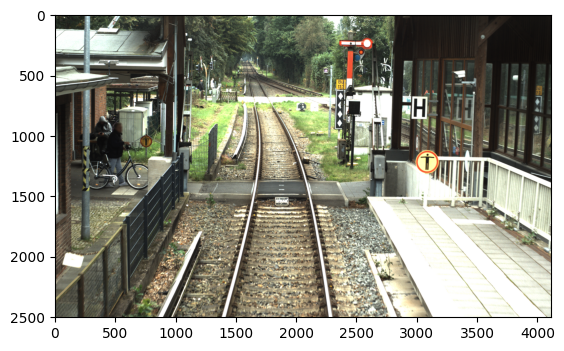

In [22]:
# pick a random image
df_test = df_split[df_split["path"] == df_split["path"].values[10]]
print(df_test["path"].iloc[0])
img = cv2.imread(f"./orig_data/DB/{df_test['path'].iloc[0]}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_ = plt.imshow(img)

### Generate mask

First, we have to find a good thickness for the polylines such that the tracks are covered. 

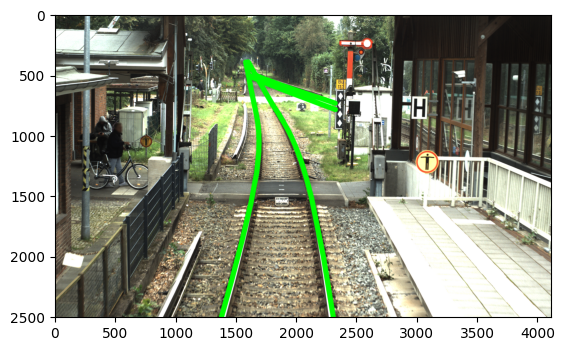

In [23]:
thickness = int(img.shape[1] / 100)
img_temp = img.copy()
for idx, row in df_test.iterrows():
    cv2.polylines(
        img_temp,
        np.int32([row["poly2d"]]),
        isClosed=row["closed"],
        color=(0, 255, 0),
        thickness=thickness,
    )
_ = plt.imshow(img_temp)

Next, we generate an mask image where the polyline in the given thickness is displayed in white on a black background.

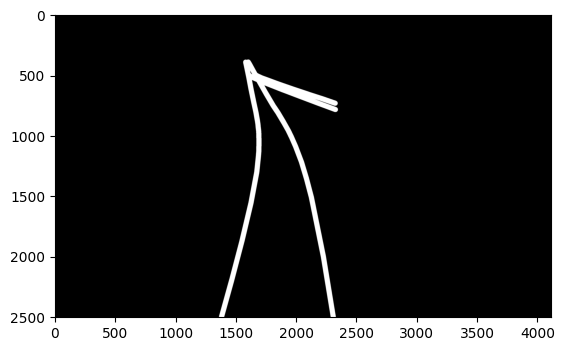

In [24]:
mask = np.zeros_like(img)
for idx, row in df_test.iterrows():
    cv2.polylines(
        mask,
        np.int32([row["poly2d"]]),
        isClosed=False,
        color=(255, 255, 255),
        thickness=thickness,
    )
_ = plt.imshow(mask)

### Identify contour of the mask

The mask image can be used to identify the countour using the opencv library.

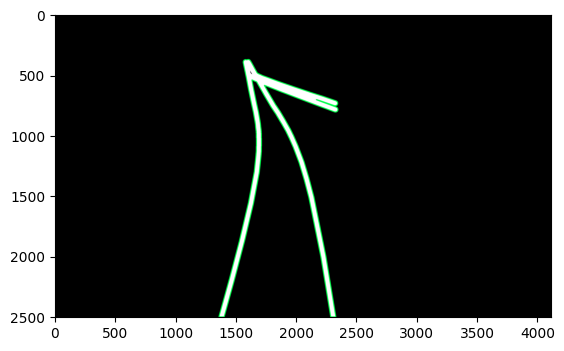

In [25]:
mask_temp = mask.copy()
imgray = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0.5, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
cv2.drawContours(mask_temp, contours, -1, (0, 255, 75), 8)
_ = plt.imshow(mask_temp)

The resulting number of points specifying the countour is too large for our application.

In [26]:
for c in contours:
    print(len(c))

5096


### Simplify contour

By approximating the countour, we can significantly reduce the number of points required to specify the contour.

In [27]:
contours_small = []
for idx, contour in enumerate(contours):
    contour = np.append(contour, [contour[0]], axis=0)
    con_short = cv2.approxPolyDP(contour, epsilon=0.8, closed=True)
    points = [p for point in con_short for p in point[0]]
    points += [points[0], points[1]]
    contours_small.append(points)

In [28]:
for c in contours_small:
    print(len(c))

1296


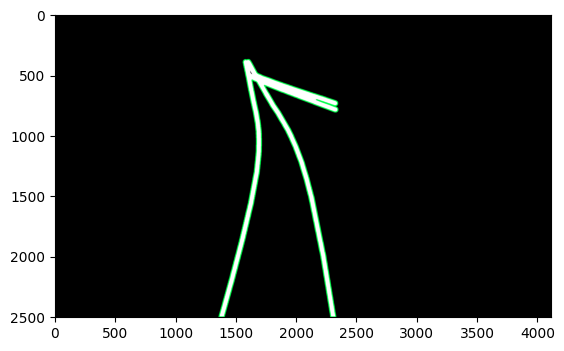

In [29]:
mask_temp = mask.copy()
cv2.drawContours(mask_temp, [con_short], -1, (0, 255, 75), 8)
_ = plt.imshow(mask_temp)

## Foramlize ideas

In the following, we formalize the ideas by defining functions that can be called each time we generate the label for an image.

An example is given below

In [30]:
# Select a random image
df_test["path"].iloc[0]

'10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png'

In [31]:
# generate mask
mask = generate_mask_df(df_db, path="./orig_data/DB/", file=df_test["path"].iloc[0])
# generate contour
lables, coordinates = find_contours(mask)

10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png


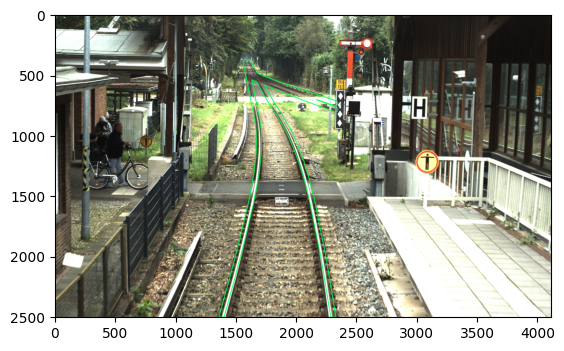

In [32]:
# display result
img_temp = img.copy()
for c in coordinates:
    cv2.drawContours(img_temp, [np.array(c)], -1, (0, 255, 75), 5)
_ = plt.imshow(img_temp)

## Generate folder structure and write files - DB

In [66]:
df_split.to_csv(
    f"./dataframe_dumps/df_split_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
)

In [35]:
datasets = {}
datasets["data_all"] = df_split
datasets["data_ir"] = df_split[df_split["sensor"].str.contains("ir_")]
datasets["data_highres"] = df_split[df_split["sensor"].str.contains("rgb_highres")]
datasets["data_rgb"] = df_split[
    df_split["sensor"].str.contains("rgb_[clr]", regex=True)
]

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_14460\744763592.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


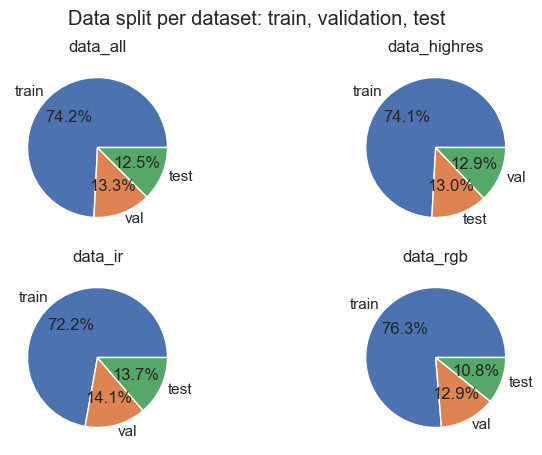

In [42]:
sns.set(rc={"figure.figsize": (8, 5)})

number_plots = len(datasets)
fig, ax = plt.subplots(2, 2)
fig.suptitle("Data split per dataset: train, validation, test")

for idx, (k, v) in enumerate(datasets.items()):
    labels = v[["path", "set"]].drop_duplicates()["set"].value_counts().index
    values = v[["path", "set"]].drop_duplicates()["set"].value_counts().values
    ax[idx % 2, idx // 2].pie(values, labels=labels, autopct="%.1f%%")
    ax[idx % 2, idx // 2].set_title(k)


fig.show()

In [69]:
path_data = "../rail_detection/datasets/"
path_yml = "../rail_detection/"
for k, v in datasets.items():
    write_dataset_to_directory(v, path_yml=path_yml, path_data=path_data, dataset=k)

## Generate folder structure and write files - DB

In [ ]:
# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]

In [35]:
path_data = "../rail_detection/datasets/"
path_yml = "../rail_detection/"

In [ ]:
write_dataset_to_directory(
    df_split_rail_sem,
    path_yml=path_yml,
    path_data=path_data,
    dataset="data_railsem",
    path_orig_data="./orig_data/rs19_val/jpgs/rs19_val/",
)

## Test labeling

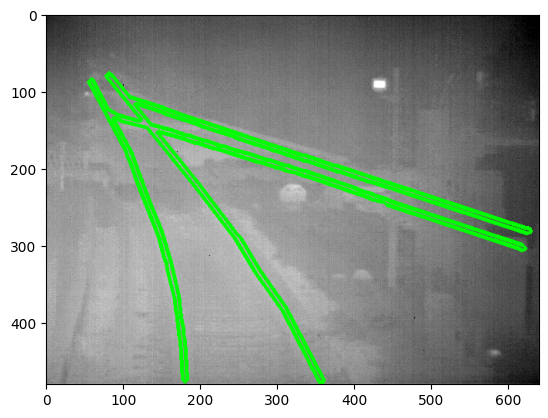

In [36]:
image = glob(f"{path_data}data_all/train/images/*")[0]
label = image.replace("png", "txt").replace("image", "label")

with open(label, "r") as f:
    labels = f.read().splitlines()
img = cv2.imread(image)
h, w = img.shape[:2]

for label in labels:
    class_id, *poly = label.split(" ")

    poly = np.asarray(poly, dtype=np.float16).reshape(-1, 2)  # Read poly, reshape
    poly *= [w, h]  # Unscale

    cv2.polylines(img, [poly.astype("int")], True, (0, 255, 0), 4)  # Draw Poly Lines
    # cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw area
    plt.imshow(img)

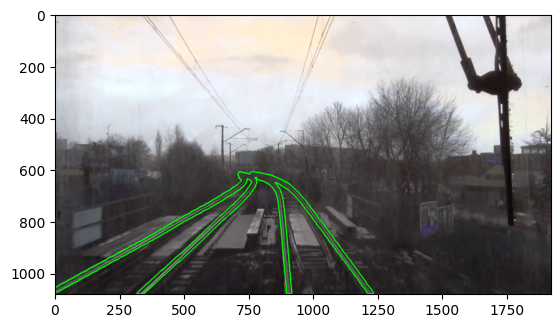

In [37]:
image = glob(f"{path_data}data_railsem/train/images/*")[4]
label = image.replace("jpg", "txt").replace("image", "label")

with open(label, "r") as f:
    labels = f.read().splitlines()
img = cv2.imread(image)
h, w = img.shape[:2]

for label in labels:
    class_id, *poly = label.split(" ")

    poly = np.asarray(poly, dtype=np.float16).reshape(-1, 2)  # Read poly, reshape
    poly *= [w, h]  # Unscale

    cv2.polylines(img, [poly.astype("int")], True, (0, 255, 0), 4)  # Draw Poly Lines
    # cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw area
    plt.imshow(img)